In [1]:
from pathlib import Path
import os, sys
from geopy.geocoders import GoogleV3, Nominatim
import geopandas as gpd
import pandas as pd

DIR = Path('..')
sys.path.insert(0, str(DIR))
from SCanalyzer import SCanalyzer
from SCanalyzer.busSim import BusSim
from SCanalyzer.busSim.manager import LocalManager
from shapely.geometry import Point
from matplotlib.lines import Line2D

manger init
mangager register
mangager register


In [2]:
%matplotlib inline

In [3]:
DATA_PATH = "../data/loop_gtfs.zip"
OUT_PATH = "/tmp/output"
DAY = "monday"
START_TIME = "10:00:00"
ELAPSE_TIME = "04:00:00"
AVG_WALKING_SPEED = 1.4 # 1.4 meters per second
MAX_WALKING_MIN = 8
city = gpd.read_file("../data/plot/background/madison-shp")
print(city.crs)
lakes = gpd.read_file("../data/plot/background/water-shp")
print(lakes.crs)
street = gpd.read_file("../data/plot/background/street-shp")
print(street.crs)
max_lon = city.bounds.maxx.max()
min_lon = city.bounds.minx.min()
max_lat = city.bounds.maxy.max()
min_lat = city.bounds.miny.min()
geolocator = Nominatim(user_agent="wisc_bazarr_demo")
sc = SCanalyzer(DATA_PATH)
manager = LocalManager(DATA_PATH, OUT_PATH, None)
busSim = BusSim(manager, DAY, START_TIME, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN)

epsg:4326
epsg:4326
epsg:4326
zf namelist ['calendar.txt', 'routes.txt', 'shapes.txt', 'stop_times.txt', '__MACOSX/._stop_times.txt', 'stops.txt', 'trips.txt', 'stops_meter.txt']
['calendar.txt', 'routes.txt', 'shapes.txt', 'stop_times.txt', '__MACOSX/._stop_times.txt', 'stops.txt', 'trips.txt', 'stops_meter.txt']
new Stops df     stop_id    stop_name   stop_lat   stop_lon         stop_x        stop_y
0         5   Blackberry  43.074226 -89.433420  301890.765912  4.771932e+06
1         6    Blueberry  43.073223 -89.445780  300881.254742  4.771849e+06
2        11  Dragonfruit  43.067204 -89.400461  304551.799656  4.771074e+06
3         9    Cranberry  43.067455 -89.428270  302288.262501  4.771167e+06
4         7       Cherry  43.068709 -89.445436  300894.584810  4.771347e+06
5         8      Coconut  43.067956 -89.436853  301591.011945  4.771243e+06
6         3      Avocado  43.073944 -89.416404  303275.250043  4.771860e+06
7         2       Apicot  43.072690 -89.408851  303886.188648  

In [4]:
cache = {}
def geocode(addr):
    if not "madison" in addr.lower():
        addr += ", Madison WI"
    if not addr in cache:
        cache[addr] = geolocator.geocode(addr)
    return cache[addr]

In [5]:
def flatten(s):
    return gpd.GeoDataFrame({"geometry": gpd.GeoSeries([s.unary_union])})

In [6]:
def plot(starts=[]):      
    ax = lakes.boundary.plot(color="lightblue", zorder=1, linewidth=2, figsize=(16, 16))
    lakes.plot(color="lightblue", ax=ax, alpha=0.2, zorder=1)
    city.plot(color="black", alpha=0.05, ax=ax, zorder=2)
    street.plot(color="black", alpha=0.03, ax=ax, zorder=3)

    leg_lines = []
    leg_text = []
    
    colors = ["orange", "blue", "green", "yellow"]
    
    zorder = 4
    
    bubbles = []
    
    for i, addr in enumerate(starts):
        zorder += 10
        location = geocode(addr)
        lat, lon = (location.latitude, location.longitude)
        # check if the point is indeed in Madison
        if lat > max_lat or lat < min_lat or lon > max_lon or lon < min_lon:
            print(lat, lon)
            print(f"Looks like {start} is not in madison.")
            continue
        gdf = busSim.get_gdf(start_point=(lat, lon))
        print(gdf.crs)
        gdf = gdf.to_crs(epsg=4326)
        
        color = colors[i % len(colors)]
        bubble = flatten(gdf.difference(lakes.unary_union))
        bubble["color"] = color
        bubbles.append(bubble)
        bubble.boundary.plot(color=color, ax=ax, linewidth=2, zorder=zorder+2)
        gdf["geometry"].to_crs('+proj=cea').centroid.to_crs(gdf.crs).plot(color="black", ax=ax, markersize=2, zorder=zorder+3)
        #gdf["geometry"].centroid.plot(color="black", ax=ax, markersize=2, zorder=zorder+3)
        start = gpd.GeoSeries([Point(lon, lat)])
        start.plot(ax = ax, marker='o', color="black", markersize=160, zorder=100)
        
        leg_lines.append(Line2D([0], [0], color=color, lw=4))
        leg_text.append(addr)
        
    df = pd.concat(bubbles)
    df.plot(alpha=0.1, ax=ax, color=df["color"], zorder=zorder)

    leg = ax.legend(leg_lines, leg_text, prop={"size": 18}, loc="upper left")
    leg.get_frame().set_facecolor("white")
    leg.get_frame().set_edgecolor("white")

    ax.set_axis_off()
    #print(f'new Stops df {stops_df}')
def demo(addrs_str):
    plot([s.strip() for s in addrs_str.split("\n") if s.strip() != ""])

EPSG:32616


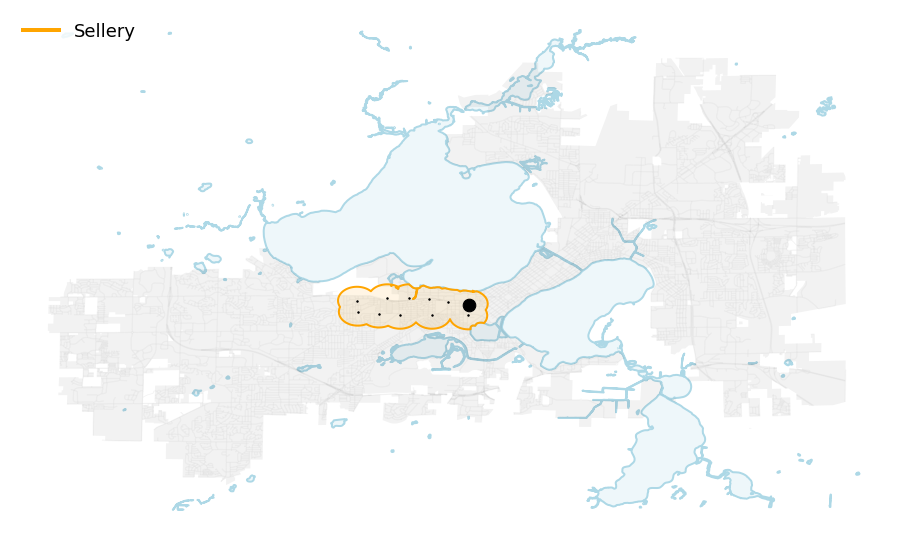

In [7]:
demo("""
Sellery
""")